In [39]:
import os
import sys
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk
import json

%matplotlib inline

## Lightcurve

In [40]:
# Function to wrap around juliet's get_TESS_data function to deal with multiple TESS sectors
def juliet_get_tess_data(lkf):
    for indf,thisf in enumerate(lkf):
        thist,thisf,thisferr = juliet.get_TESS_data(thisf)
        if indf == 0:
            t,f,ferr = thist,thisf,thisferr
        else:
            t,f,ferr = np.concatenate((t,thist)), np.concatenate((f,thisf)), \
                np.concatenate((ferr,thisferr))
    
    return t,f,ferr

In [41]:
# Basic constants
tesst0 = 2457000.0  # BJD offset for TESS timestamps

p1 = 3.37923577236328  # period in days
perr1 = .0001425314  # error on period in days
tc1 = 2459420.207144  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0018298243  # transit midpoint in days

In [42]:
# download the lightcurve using lightkurve ;)
# Make sure to change the my_dir to the download folder you want!
my_dir = './'
lkfile = lk.search.search_lightcurvefile('TOI 4439', mission='TESS')
lkf = lkfile.download_all(download_dir=my_dir)

In [43]:
# juliet needs the fits file
lkf = glob.glob(os.path.join(my_dir, 'mastDownload/*/*/tess*.fits'))
print(lkf)

['./mastDownload/TESS/tess2022164095748-s0053-0000000267545252-0226-s/tess2022164095748-s0053-0000000267545252-0226-s_lc.fits', './mastDownload/TESS/tess2022217014003-s0055-0000000267545252-0242-s/tess2022217014003-s0055-0000000267545252-0242-s_lc.fits', './mastDownload/TESS/tess2021175071901-s0040-0000000267545252-0211-s/tess2021175071901-s0040-0000000267545252-0211-s_lc.fits', './mastDownload/TESS/tess2021204101404-s0041-0000000267545252-0212-s/tess2021204101404-s0041-0000000267545252-0212-s_lc.fits']


In [44]:
t,f,ferr = juliet_get_tess_data(lkf)

(2390.6553572621588, 2824.2646124455414)

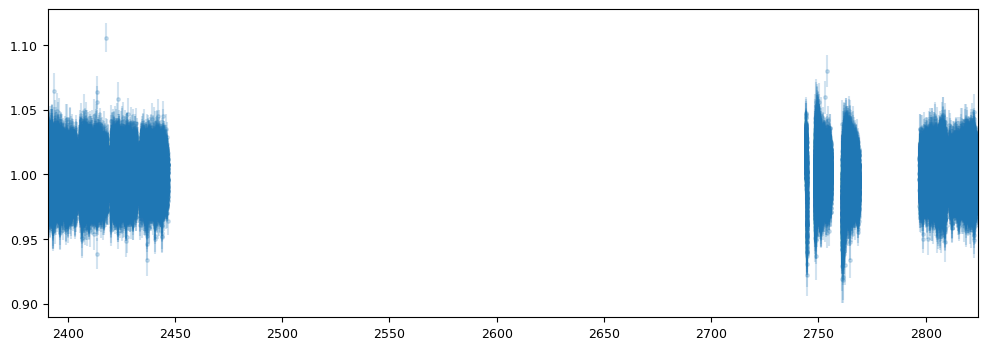

In [45]:
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Plot data:
plt.figure(figsize=(12,4))
plt.errorbar(t,f, yerr=ferr, fmt='.',alpha=0.2)
plt.xlim([np.min(t),np.max(t)])

## B Band

In [46]:
photo_file = f'./photometry_data/TOI-4439-B.csv'
df = pd.read_csv(photo_file)
print(df.head())
t = np.array(df['time'])
flux = np.array(df['flux'])
flux_err = np.array(df['flux_err'])

# normalize flux
flux_mean = flux.mean()
flux, flux_err = flux/flux_mean, flux_err/flux_mean

times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, flux, flux_err

           time      flux  flux_err
0  2.459714e+06  0.257930  0.004213
1  2.459714e+06  0.250827  0.003911
2  2.459714e+06  0.245281  0.003733
3  2.459714e+06  0.245579  0.003621
4  2.459714e+06  0.246836  0.003477


In [47]:
dataset = juliet.load(priors=f'./transit_fit_4439_B/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = f'./transit_fit_4439_B')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_B/_dynesty_NS_posteriors.pkl


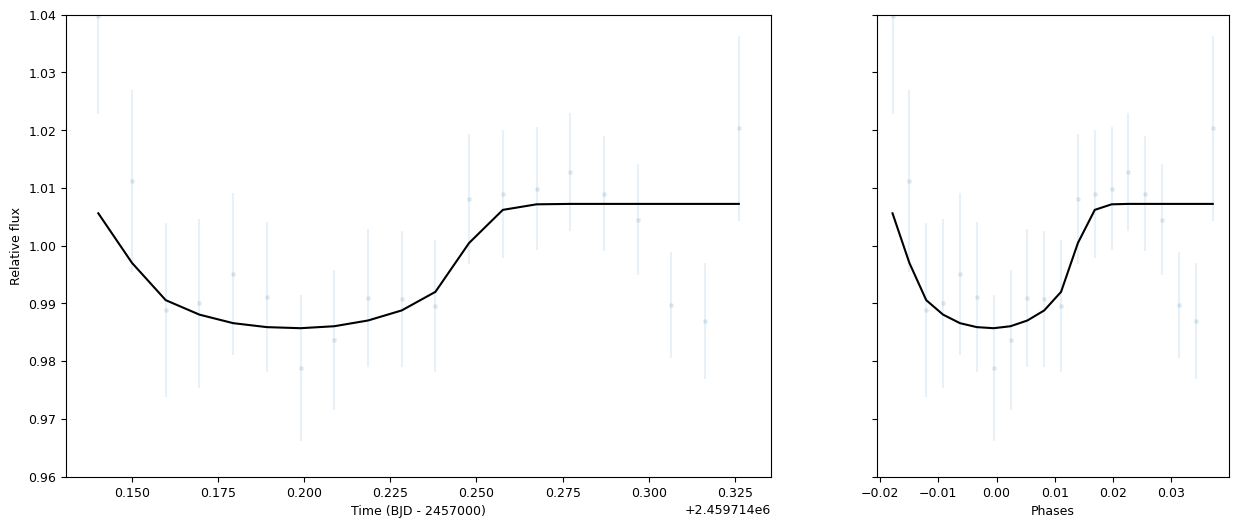

In [48]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')
plt.show()

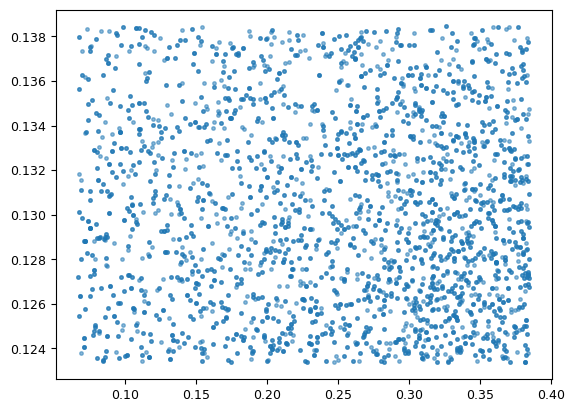

In [49]:
infile = open('./transit_fit_4439_B/_dynesty_NS_posteriors.pkl','rb')
posteriors = pickle.load(infile)
infile.close()

# extract r1 and r2
r1, r2 = posteriors['posterior_samples']['r1_p1'],\
         posteriors['posterior_samples']['r2_p1']
         
# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)

In [50]:
# Save fit lightcurves
results_file = 'fit_results.json'
try:
    with open(results_file, 'r') as f:
        results = json.load(f)
except:
    results = {} # dictionary to record the test results
    
results['B-band'] = {
    'times_lc':dataset.times_lc['TESS'].tolist(), 
    'data_lc':dataset.data_lc['TESS'].tolist(), 
    'errors_lc':dataset.errors_lc['TESS'].tolist(), 
    'transit_model':transit_model.tolist(), 'phases':phases.tolist(), 'idx':idx.tolist()
    }

with open(results_file, 'w') as f:
    json.dump(results, f)

## R Band

In [51]:
photo_file = f'./photometry_data/TOI-4439-R.csv'
df = pd.read_csv(photo_file)
print(df.head())
t = np.array(df['time'])
flux = np.array(df['flux'])
flux_err = np.array(df['flux_err'])

# normalize flux
flux_mean = flux.mean()
flux, flux_err = flux/flux_mean, flux_err/flux_mean

times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, flux, flux_err

           time      flux  flux_err
0  2.459714e+06  0.286553  0.001315
1  2.459714e+06  0.283441  0.001267
2  2.459714e+06  0.282399  0.001258
3  2.459714e+06  0.282770  0.001205
4  2.459714e+06  0.284356  0.001146


In [52]:
dataset = juliet.load(priors=f'./transit_fit_4439_R/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = f'./transit_fit_4439_R')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_R/_dynesty_NS_posteriors.pkl


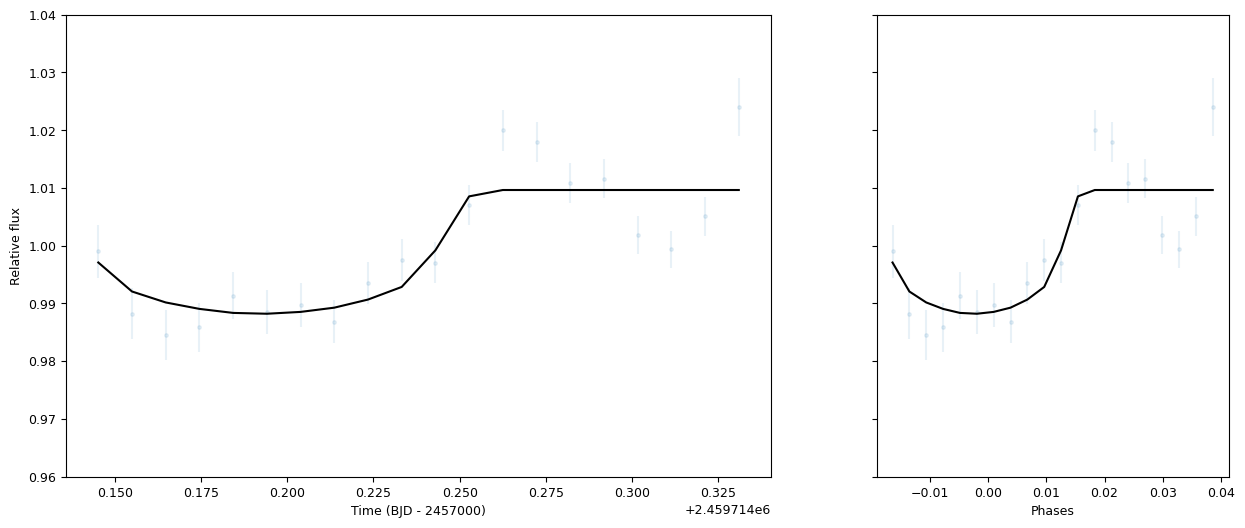

In [53]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')
plt.show()

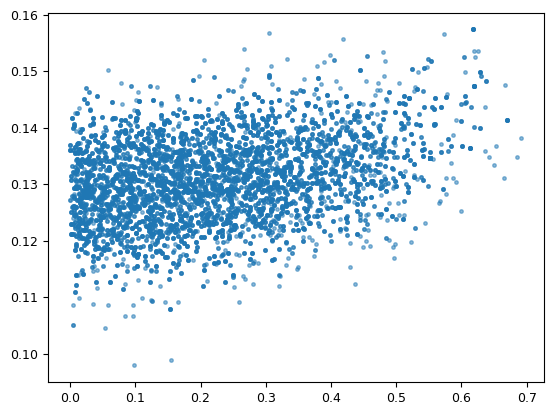

In [54]:
infile = open('./transit_fit_4439_R/_dynesty_NS_posteriors.pkl','rb')
posteriors = pickle.load(infile)
infile.close()

# extract r1 and r2
r1, r2 = posteriors['posterior_samples']['r1_p1'],\
         posteriors['posterior_samples']['r2_p1']
         
# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)

In [55]:
# Save fit lightcurves
results_file = 'fit_results.json'
try:
    with open(results_file, 'r') as f:
        results_dict = json.load(f)
except:
    results_dict = {} # dictionary to record the test results
    
results_dict['R-band'] = {
    'times_lc':dataset.times_lc['TESS'].tolist(), 
    'data_lc':dataset.data_lc['TESS'].tolist(), 
    'errors_lc':dataset.errors_lc['TESS'].tolist(), 
    'transit_model':transit_model.tolist(), 'phases':phases.tolist(), 'idx':idx.tolist()
    }

with open(results_file, 'w') as f:
    json.dump(results_dict, f)

In [70]:
results.posteriors['posterior_samples']

{'unnamed': array([[ 3.37922705e+00,  2.45971418e+06,  7.77574410e-01, ...,
          1.57684340e+03, -7.00251639e-03,  1.27836327e+01],
        [ 3.37908290e+00,  2.45971419e+06,  4.25692273e-01, ...,
          1.54576091e+03, -1.34062803e-02,  2.10165679e-01],
        [ 3.37925213e+00,  2.45971419e+06,  7.61961729e-01, ...,
          1.70491455e+03, -5.95126403e-03,  2.01908765e-01],
        ...,
        [ 3.37933383e+00,  2.45971419e+06,  4.18536936e-01, ...,
          1.25659599e+03, -1.01992530e-02,  9.81193811e+02],
        [ 3.37933383e+00,  2.45971419e+06,  4.18536936e-01, ...,
          1.25659599e+03, -1.01992530e-02,  9.81193811e+02],
        [ 3.37933383e+00,  2.45971419e+06,  4.18536936e-01, ...,
          1.25659599e+03, -1.01992530e-02,  9.81193811e+02]]),
 'loglike': array([57.90556843, 58.73515846, 59.14568865, ..., 70.30471929,
        70.30471929, 70.30471929]),
 'P_p1': array([3.37922705, 3.3790829 , 3.37925213, ..., 3.37933383, 3.37933383,
        3.37933383]),
 't